In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 1
import os
from PIL import Image
import imageio
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!date

2018年 10月 12日 星期五 05:36:20 CST


In [3]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/prepare_weight/2018-10-12_02-50-13'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
INFO:tensorflow:Restoring parameters from ../data/prepare_weight/2018-10-12_02-50-13


# 初始化棋局

In [82]:
HUMAN_FIRST = False
MOVE = 'human' if HUMAN_FIRST else 'computer'


In [83]:
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
moves = []
#for i in moves[:]: 
#   statestr = GameBoard.sim_do_action(i,statestr)
#   imgs_for_gif.append(board_visualizer.get_board_img(statestr))
#   state.do_moae(i)
#mgs_for_gif = imgs_for_gif[:]
#mageio.mimsave('../data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

# 从这里开始下棋

In [88]:
assert(MOVE in ['human','computer'])
if MOVE == 'human':
    move = input()
    MOVE = 'computer'
else:
    network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=3200,temp_round=-1,repeat_noise=False)
    move = network_player.make_move(state=state,actual_move=False)[0]
    MOVE = 'human'
    
moves.append(move)

b2b4


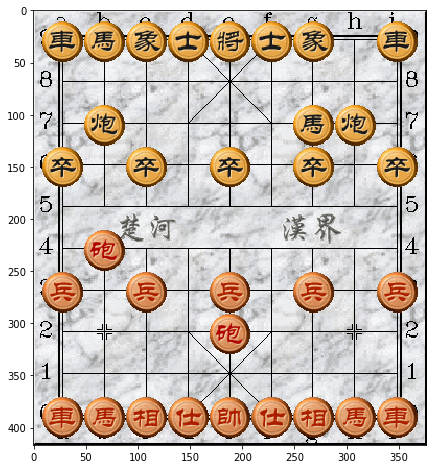

In [89]:
statestr = GameBoard.sim_do_action(move,statestr)
state.do_move(move)
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))
print(move)